# **8-1-1**

In [2]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
36/36 [==============================] - 8s 121ms/step - loss: 0.0171 - val_loss: 0.0233
Epoch 2/100
36/36 [==============================] - 4s 117ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 3/100
36/36 [==============================] - 5s 129ms/step - loss: 8.5857e-04 - val_loss: 0.0034
Epoch 4/100
36/36 [==============================] - 7s 185ms/step - loss: 8.4207e-04 - val_loss: 0.0033
Epoch 5/100
36/36 [==============================] - 5s 126ms/step - loss: 7.9279e-04 - val_loss: 0.0038
Epoch 6/100
36/36 [==============================] - 3s 96ms/step - loss: 7.7636e-04 - val_loss: 0.0031
Epoch 7/100
36/36 [==============================] - 4s 103ms/step - loss: 7.8396e-04 - val_loss: 0.0032
Epoch 8/100
36/36 [==============================] - 4s 109ms/step - loss: 7.4796e-04 - val_loss: 0.0030
Epoch 9/100
36/36 [==============================] - 3s 96ms/step - loss: 7.0517e-04 - val_loss: 0.0031
Epoch 10/100
36/36 [==============================] - 3s 95ms/ste

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 29ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 169.78945407197708
Testing RMSE: 170.60869803595284
Testing MAPE: 24527.946171970045
---------------------------
Validation MAE: 159.5313401172319
Validation RMSE: 160.66348917853853
Validation MAPE: 25909.46201514079


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.48257149 0.48354554 0.4767272  0.46260349 0.48542406 0.47964934
 0.49147708 0.48389341 0.4722744  0.49627774 0.50302651 0.49746052
 0.49544284 0.51986363 0.5055312  0.53663118 0.54177973 0.53252626
 0.54595422 0.54539762 0.54525847 0.54623252 0.54150143 0.55325958
 0.53948375 0.55291171 0.56313922 0.54950254 0.53621373 0.52981284
 0.53572671 0.53009114 0.53704863 0.52723857 0.53029987 0.52188131
 0.51019272 0.52222918 0.5232728  0.49773882 0.49405135 0.49613859
 0.47596187 0.47735337 0.4750574  0.47930147 0.48445001 0.50226118
 0.50434843 0.49704307 0.50142629 0.49314687 0.48932025 0.48340639
 0.48027552 0.45877687 0.47491825 0.45808112 0.46956098 0.47408335
 0.47262228 0.47470952 0.48013637 0.48229319 0.48904195 0.50114799
 0.50080011 0.51520212 0.51972448 0.51833299 0.5063661  0.49558199
 0.48959855 0.48667641 0.47867529 0.48417171 0.4753357  0.48778961
 0.48284979 0.47046546 0.46030752 0.46636054 0.46754331 0.45828985
 0.46183817 0.48618938 0.48486746 0.48041467 0.469

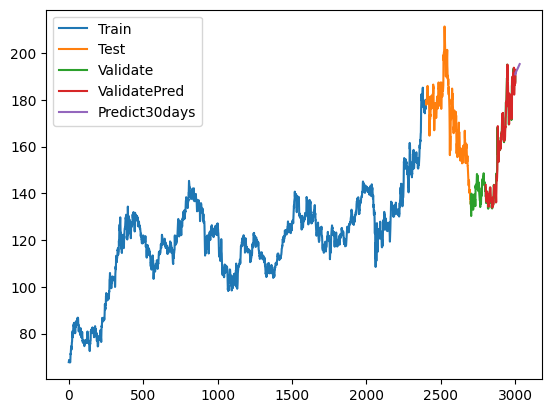

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **7-2-1**

In [16]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
32/32 [==============================] - 8s 149ms/step - loss: 0.0153 - val_loss: 0.0243
Epoch 2/100
32/32 [==============================] - 3s 100ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 3/100
32/32 [==============================] - 3s 100ms/step - loss: 6.8671e-04 - val_loss: 0.0024
Epoch 4/100
32/32 [==============================] - 4s 118ms/step - loss: 6.5612e-04 - val_loss: 0.0025
Epoch 5/100
32/32 [==============================] - 3s 105ms/step - loss: 6.2558e-04 - val_loss: 0.0024
Epoch 6/100
32/32 [==============================] - 3s 101ms/step - loss: 6.2202e-04 - val_loss: 0.0024
Epoch 7/100
32/32 [==============================] - 3s 100ms/step - loss: 6.0591e-04 - val_loss: 0.0025
Epoch 8/100
32/32 [==============================] - 4s 125ms/step - loss: 5.8913e-04 - val_loss: 0.0027
Epoch 9/100
32/32 [==============================] - 3s 100ms/step - loss: 5.9261e-04 - val_loss: 0.0023
Epoch 10/100
32/32 [==============================] - 3s 101ms/

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 21ms/step


In [26]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [27]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 162.12843456199568
Testing RMSE: 162.96772468375607
Testing MAPE: 24760.288596674316
---------------------------
Validation MAE: 157.38280618168503
Validation RMSE: 158.42753713070988
Validation MAPE: 25560.579630871056


In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=240
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.48257149 0.48354554 0.4767272  0.46260349 0.48542406 0.47964934
 0.49147708 0.48389341 0.4722744  0.49627774 0.50302651 0.49746052
 0.49544284 0.51986363 0.5055312  0.53663118 0.54177973 0.53252626
 0.54595422 0.54539762 0.54525847 0.54623252 0.54150143 0.55325958
 0.53948375 0.55291171 0.56313922 0.54950254 0.53621373 0.52981284
 0.53572671 0.53009114 0.53704863 0.52723857 0.53029987 0.52188131
 0.51019272 0.52222918 0.5232728  0.49773882 0.49405135 0.49613859
 0.47596187 0.47735337 0.4750574  0.47930147 0.48445001 0.50226118
 0.50434843 0.49704307 0.50142629 0.49314687 0.48932025 0.48340639
 0.48027552 0.45877687 0.47491825 0.45808112 0.46956098 0.47408335
 0.47262228 0.47470952 0.48013637 0.48229319 0.48904195 0.50114799
 0.50080011 0.51520212 0.51972448 0.51833299 0.5063661  0.49558199
 0.48959855 0.48667641 0.47867529 0.48417171 0.4753357  0.48778961
 0.48284979 0.47046546 0.46030752 0.46636054 0.46754331 0.45828985
 0.46183817 0.48618938 0.48486746 0.48041467 0.469

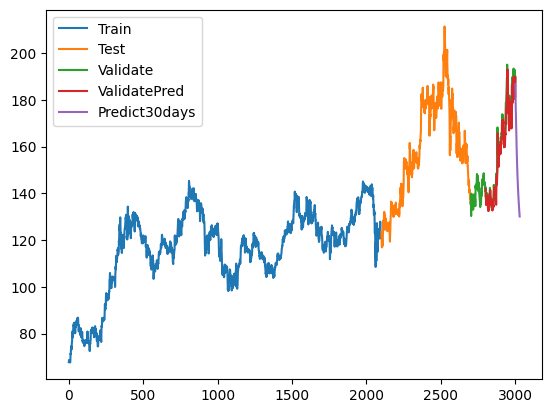

In [29]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()

# **6-2-2**

In [30]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/TM.csv')
df1=df.reset_index()['Close']

In [32]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [33]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [34]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [37]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [38]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
27/27 [==============================] - 8s 143ms/step - loss: 0.0209 - val_loss: 0.0033
Epoch 2/100
27/27 [==============================] - 3s 117ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 3/100
27/27 [==============================] - 3s 102ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/100
27/27 [==============================] - 3s 102ms/step - loss: 7.0419e-04 - val_loss: 0.0019
Epoch 5/100
27/27 [==============================] - 3s 104ms/step - loss: 6.7325e-04 - val_loss: 0.0017
Epoch 6/100
27/27 [==============================] - 3s 127ms/step - loss: 6.4700e-04 - val_loss: 0.0015
Epoch 7/100
27/27 [==============================] - 3s 103ms/step - loss: 6.2396e-04 - val_loss: 0.0018
Epoch 8/100
27/27 [==============================] - 3s 102ms/step - loss: 5.9953e-04 - val_loss: 0.0014
Epoch 9/100
27/27 [==============================] - 3s 102ms/step - loss: 5.9551e-04 - val_loss: 0.0014
Epoch 10/100
27/27 [==============================] - 3s 129ms/step

In [39]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

16/16 [==============================] - 0s 21ms/step


In [40]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [41]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# MAE
MAE_val = np.mean(np.abs(y_pred_val - yval))
MAE_test = np.mean(np.abs(y_pred - ytest))
# MAPE
MAPE_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
MAPE_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Testing MAE:', MAE_test)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', MAPE_test)
print('---------------------------')

print('Validation MAE:', MAE_val)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', MAPE_val)

Testing MAE: 139.7824372359094
Testing RMSE: 140.59240511020627
Testing MAPE: 28742.464645983193
---------------------------
Validation MAE: 160.31796548470194
Validation RMSE: 161.61661861435977
Validation MAPE: 26052.16979079229


In [42]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=540
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.75050442 0.75579211 0.77165519 0.77249009 0.7660892  0.74013776
 0.73582411 0.72768385 0.73443262 0.74062478 0.75725318 0.75787936
 0.7816044  0.77903013 0.78918806 0.79204063 0.77673415 0.78508314
 0.75613998 0.76337577 0.77499478 0.8123565  0.81228693 0.8334377
 0.82494956 0.81409587 0.82321019 0.81715717 0.81694845 0.81520907
 0.78056077 0.7641411  0.76678494 0.76984624 0.80372921 0.79885897
 0.81367842 0.83350727 0.79899812 0.78710081 0.79809365 0.75474849
 0.78717039 0.8287066  0.83281152 0.80985181 0.79531065 0.80136367
 0.79120573 0.80804286 0.82279274 0.81479162 0.80734711 0.81013011
 0.81861824 0.82550616 0.91525777 0.899673   0.91915397 0.92395464
 0.92332846 0.93411257 0.96688235 1.         0.99526891 0.97286579
 0.93773047 0.93112085 0.91929312 0.90489112 0.90009045 0.88033118
 0.85104014 0.87309539 0.91010923 0.8960551  0.9185278  0.91762332
 0.89918597 0.90169067 0.92311974 0.9304251  0.88200097 0.87017324
 0.84415223 0.84714395 0.85340569 0.82724553 0.8441

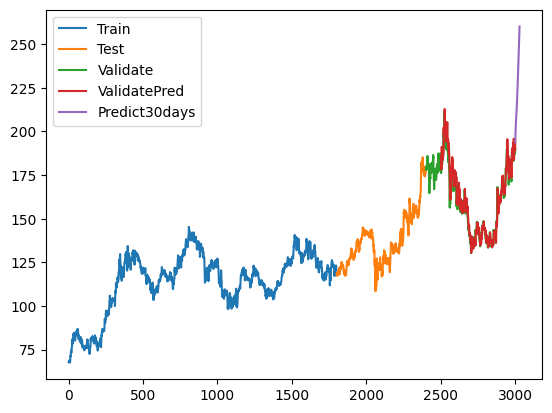

In [43]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
#plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Validate','ValidatePred','Predict30days'])
plt.show()